In [1]:
import pickle
import dm_den
import dm_den_viz
import scipy
import sklearn
import h5py
import cropper
import numpy as np
from adjustText import adjust_text
from IPython.display import display, Latex, HTML

In [2]:
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from matplotlib.lines import Line2D

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18
rcParams['figure.facecolor']='white'

In [3]:
with open('/data17/grenache/staudt/dm_den/rot_dat.pkl','rb') as f:
    d = pickle.load(f)

In [4]:
df_fname = 'dm_den_202202140946.h5'
df = dm_den.load_data(df_fname)

In [5]:
for galname in d:
    df.loc[galname,'v_cool_gas'] = np.mean(d[galname])

In [6]:
df[['v_cool_gas']]

,v_cool_gas
m12b,280.322469
m12c,235.881527
m12f,260.042251
m12i,236.104356
m12m,286.559579
m12r,142.644444
m12w,113.264383
m12z,106.301720
Romeo,241.452658
Juliet,208.129923


In [7]:
#dm_den.save_data(df,'dm_den_20220613.h5')

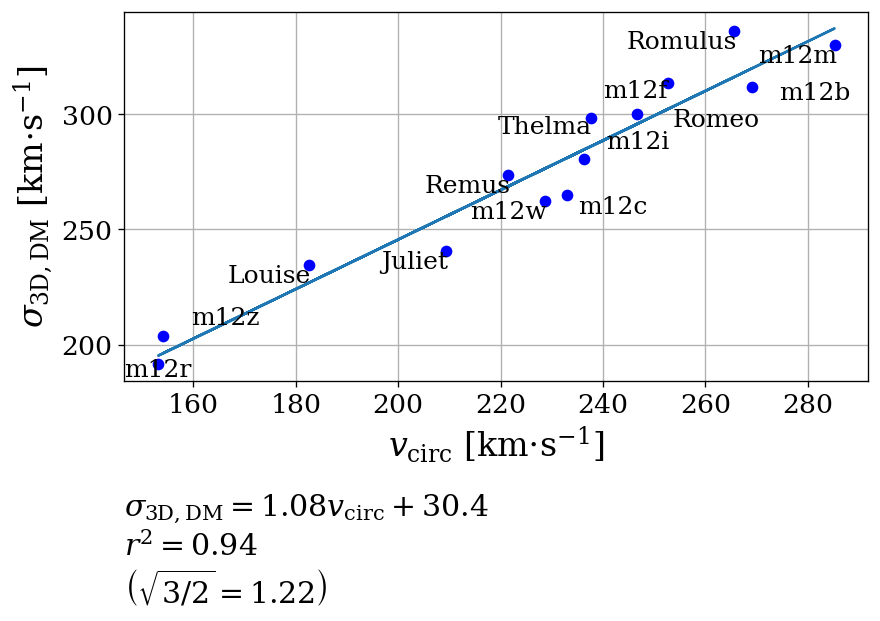

In [8]:
mlr_res = dm_den.mlr('dm_den_202202140946.h5', xcols=['vcirc_R0'], 
                     ycol='disp_dm_solar',
                     xscales=None, yscale='linear')
coefs, intercept, r2, Xs, ys, ys_pred = mlr_res[:6]

fig = plt.figure(figsize=(8,4), dpi=120)
ax = fig.add_subplot(111)
dm_den_viz.fill_ax(ax, df, ycol='disp_dm_solar', 
                   ylabel='$\sigma_\mathrm{3D,DM}$ [km$\cdot}$s$^{-1}$]',
                   xcol='vcirc_R0', xadjustment=None, 
                   xlabel='$v_\mathrm{circ}$ [km$\cdot}$s$^{-1}$]',
                   showcorr=False)
ax.plot(Xs.values[0], ys_pred)
ax.annotate('$\sigma_\mathrm{{3D,DM}}={0:0.2f}v_\mathrm{{circ}}+{1:0.1f}$\n'
            '$r^2={2:0.2f}$\n'
            '$\\left(\sqrt{{3/2}}=1.22\\right)$'.format(coefs[0], intercept, 
                                                        r2),
            (0,-0.6),
            xycoords='axes fraction', fontsize=18)
plt.show()

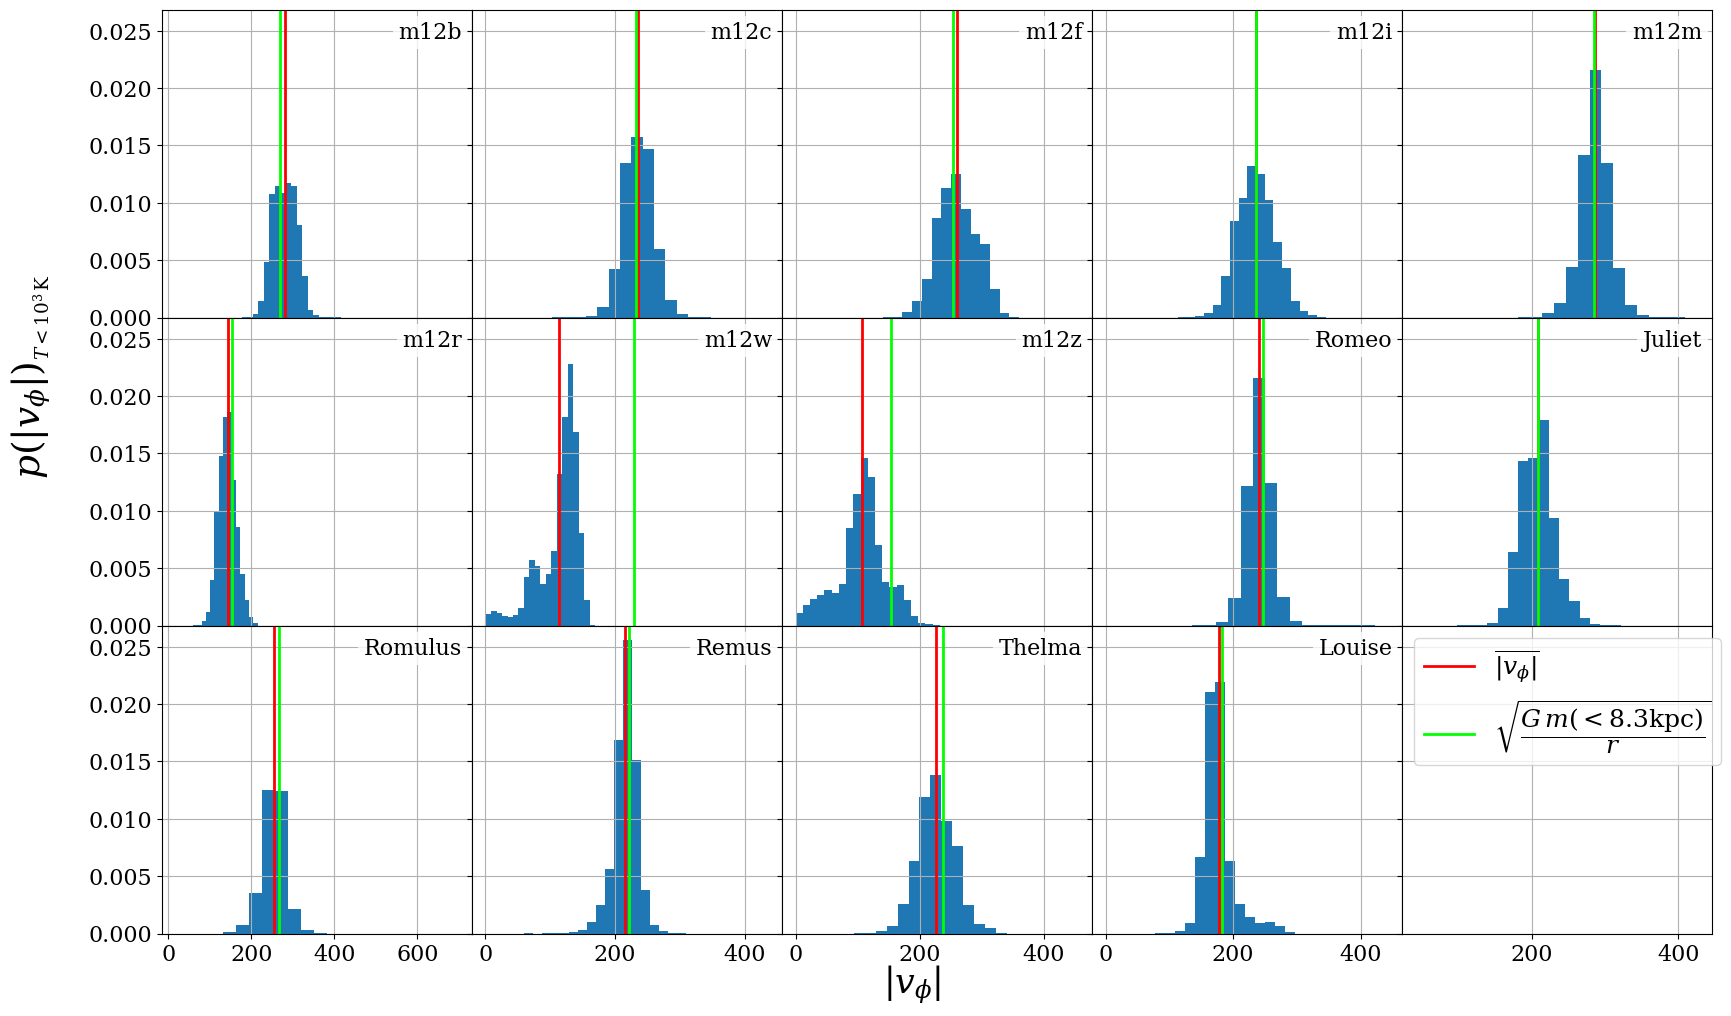

In [9]:
custom_lines = [Line2D([0], [0], color='r', lw=2.),
                Line2D([0], [0], color='#00ff00', lw=2.)]

#plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

fig,axs=plt.subplots(3,5,figsize=(20.,12.),sharey=True,sharex='col')
axs=axs.ravel()
fig.subplots_adjust(wspace=0.,hspace=0.)

kwargs_txt = dict(fontsize=16., xycoords='axes fraction',
                  va='top', ha='right', 
                  bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

for i,galname in enumerate(d):
    axs[i].hist(d[galname],bins=20,density=True)
    ############################################################################
    axs[i].axvline(x=df.loc[galname,'v_cool_gas'], color='r', lw=2)
    axs[i].axvline(x=df.loc[galname,'vcirc_R0'], color='#00ff00', lw=2)
    ############################################################################
    axs[i].annotate(galname,[0.97,0.96],**kwargs_txt)

fig.text(0.5,0.06,'$|v_\phi|$',fontsize=25, ha='center')
fig.text(0.06, 0.5, '$p(|v_\phi|)_{_{T<10^{3}\,\mathrm{K}}}$', 
         fontsize=27, ha='center',
         rotation='vertical')

axs[-1].legend(custom_lines, ['$\overline{|v_\phi|}$',
                              '$\sqrt{\dfrac{G\,m(<8.3\mathrm{kpc})}{r}}$'],
               bbox_to_anchor=(0.,1), loc='upper left')
plt.show()

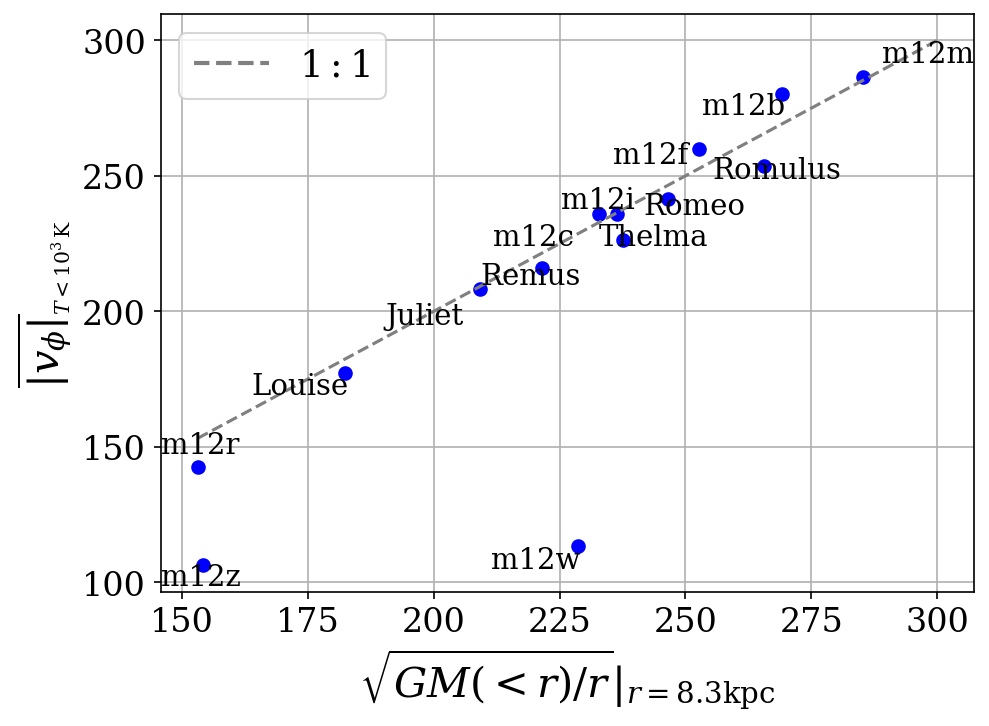

In [10]:
texts = []
xs = df['vcirc_R0']
ys = df['v_cool_gas']
names = df.index

fig = plt.figure(figsize=(7,5), dpi=150)
ax = fig.add_subplot(111)
ax.plot(df['vcirc_R0'], df['v_cool_gas'], 'bo')
ax.set_ylabel('$\\overline{|v_\phi|}_{_{T<10^{3}\,\mathrm{K}}}$')
ax.set_xlabel('$\sqrt{GM(<r)/r} \\vert_{r=8.3\mathrm{kpc}}$')
ax.plot([xs.min(),300.],[xs.min(),300.],color='gray',ls='--')
for x,y,name in zip(xs, ys, names):
    texts += [ax.annotate(name, (float(x*1.001), float(y*1.001)),
                          fontsize=14)]
adjust_text(texts, ax=ax)
#fig.set_size_inches(4., 4.*5./7., forward=True)

custom_lines = [Line2D([0], [0], ls='--', color='gray', lw=2.)]
ax.legend(custom_lines, ['$1:1$'])
               
plt.show()

In [11]:
dfd = df.drop(['m12w','m12z'])

In [12]:
#Using scipy.optimize for the fixed-power-law fit
def fixed_pwr_law(logxs, intercept):
    return logxs+intercept
res_fixed = scipy.optimize.curve_fit(fixed_pwr_law, np.log10(dfd['v_cool_gas']),
                               np.log10(dfd['disp_dm_solar']))
res_fixed = {'intercept':res_fixed[0][0]}
res_fixed['ys_pred'] = np.log10(dfd['v_cool_gas']) + res_fixed['intercept']
res_fixed['r2'] = sklearn.metrics.r2_score(np.log10(dfd['disp_dm_solar']), 
                                           res_fixed['ys_pred'])

def extract_mlr_res(res):
    'Make a human-readable dictionary out of the multi-linear regression result'
    
    res = {'coefs':res[0], 'intercept':res[1], 'r2':res[2], 
           'Xs':res[3], 'ys':res[4], 'ys_pred':res[5]}
    i_s = np.argsort(res['Xs'][0])
    res['Xs'] = res['Xs'][:,i_s]
    res['ys'] = res['ys'][i_s]
    res['ys_pred'] = res['ys_pred'][i_s]
    return res

#using (my wrapper on) sklearn for the other two fits
res_pwr = dm_den.mlr('dm_den_20220613.h5', xcols=['v_cool_gas'], 
                     ycol='disp_dm_solar',
                     xscales=['log'], yscale='log',
                     dropgals=['m12w','m12z'])
res_pwr = extract_mlr_res(res_pwr)

res_linear = dm_den.mlr('dm_den_20220613.h5', xcols=['v_cool_gas'], 
                        ycol='disp_dm_solar',
                        xscales=['linear'], yscale='linear',
                        dropgals=['m12w','m12z'])
res_linear = extract_mlr_res(res_linear)

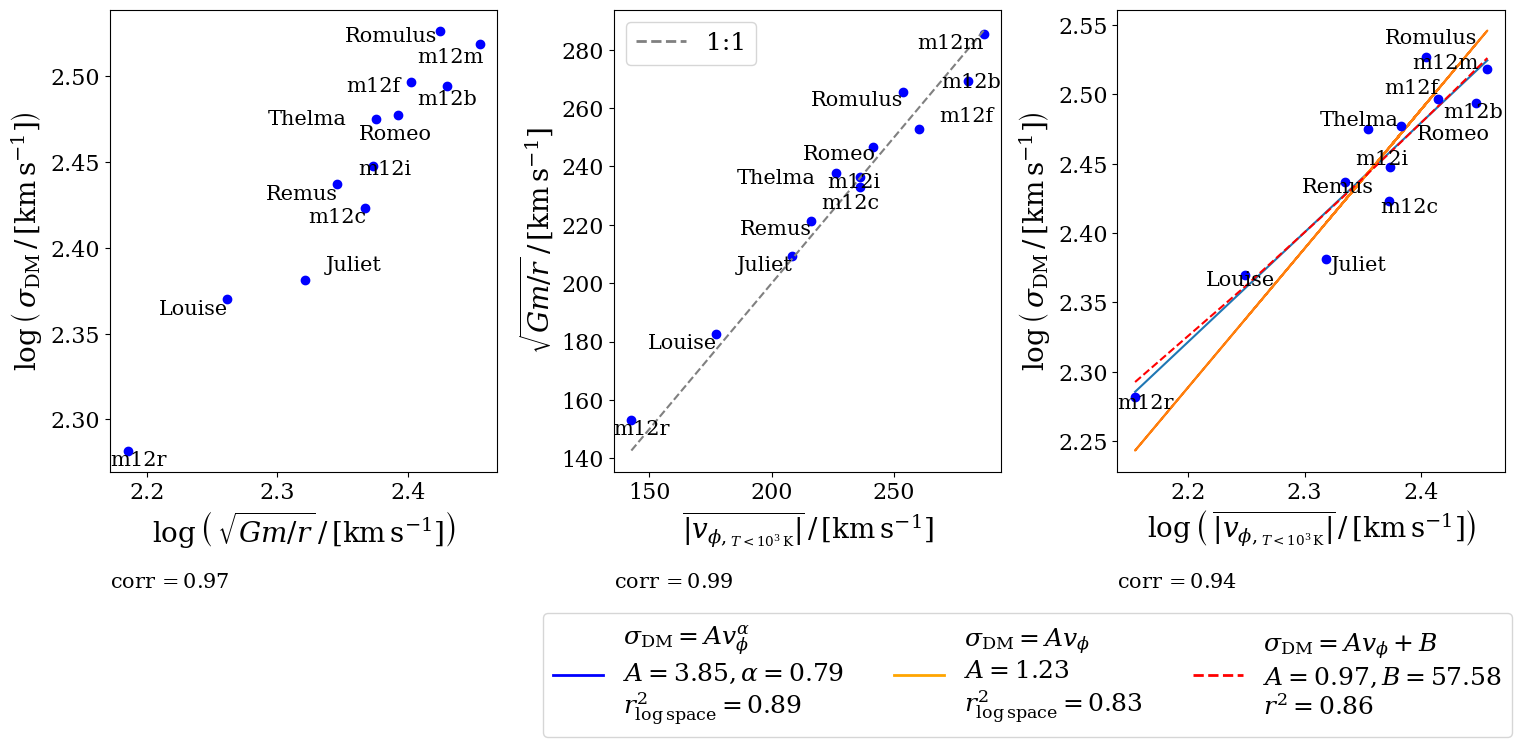

In [13]:
def loglabel(label):
    label = label.replace('$','')
    label = '$\log\\left(\,'+label+'\\right)$'
    return label

disp_label = '$\\sigma_\mathrm{DM}\,/\,'\
             '\\left[\mathrm{km\,s^{-1}}\\right]$'
vcirc_label = '$\sqrt{Gm/r}\,/\,'\
              '\\left[\mathrm{km\,s^{-1}}\\right]$'
v_cool_gas_label = '$\\overline{|v_{\phi,'\
                   '_{T<10^{3}\,\mathrm{K}}}|}'\
                   '\,/\,[\mathrm{km\,s^{-1}}]$'

fig, axs = plt.subplots(1,3,figsize=(18,6))
fig.subplots_adjust(wspace=0.3,hspace=0.)
axs = axs.ravel()
dm_den_viz.fill_ax_new(axs[0], dfd, 'vcirc_R0', 'disp_dm_solar',
                       xlabel = loglabel(vcirc_label), 
                       ylabel = loglabel(disp_label),
                       xadjustment = 'log', 
                       yadjustment = 'log')


dm_den_viz.fill_ax_new(axs[1], dfd, 'v_cool_gas', 'vcirc_R0',
                       xlabel = v_cool_gas_label,
                       ylabel = vcirc_label,
                       xadjustment = None,
                       yadjustment = None)
#Make the 1:1 line
xs = dfd['v_cool_gas']
axs[1].plot([xs.min(),xs.max()],[xs.min(),xs.max()],color='gray',ls='--')
custom_lines = [Line2D([0], [0], ls='--', color='gray', lw=2.)]
axs[1].legend(custom_lines, ['1:1'])

#Plot the power law result
axs[2].plot(res_pwr['Xs'][0], res_pwr['ys_pred'])
#Plot the power law fixed to vc^1+log(amplitude)
axs[2].plot(np.log10(dfd['v_cool_gas']), 
            np.log10(dfd['v_cool_gas'])+res_fixed['intercept'])
#Plot the linear result
axs[2].plot(np.log10(res_linear['Xs'][0]), np.log10(res_linear['ys_pred']), 
            'r--')
dm_den_viz.fill_ax_new(axs[2], dfd, 'v_cool_gas', 'disp_dm_solar', 
                       xlabel=loglabel(v_cool_gas_label),
                       ylabel=loglabel(disp_label), 
                       xadjustment = 'log',
                       yadjustment = 'log')

#Making the custom legend
custom_lines = [Line2D([0], [0], ls='-', color='blue', lw=2.),
                Line2D([0], [0], ls='-', color='orange', lw=2.),
                Line2D([0], [0], ls='--', color='red', lw=2.)]
pwr_legend = '$\sigma_\mathrm{{DM}}=Av_\phi^\\alpha$\n'\
             '$A={0:0.2f}, \\alpha={1:0.2f}$\n'\
             '$r^2_\mathrm{{log\,space}}={2:0.2}$'\
             .format(10.**res_pwr['intercept'], res_pwr['coefs'][0],
                     res_pwr['r2'])
fixed_legend = '$\sigma_\mathrm{{DM}}=Av_\phi$\n'\
               '$A={0:0.2f}$\n'\
               '$r^2_\mathrm{{log\,space}}={1:0.2}$'\
               .format(10.**res_fixed['intercept'],
                       res_fixed['r2'])
linear_legend = '$\sigma_\mathrm{{DM}}=Av_\phi+B$\n'\
                '$A={0:0.2f}, B={2:0.2f}$\n'\
                '$r^2={1:0.2}$'\
               .format(res_linear['coefs'][0],
                       res_linear['r2'],
                       res_linear['intercept'])
axs[2].legend(custom_lines, 
             [pwr_legend, fixed_legend, linear_legend],
              bbox_to_anchor=(1.05,-0.28), loc='upper right', ncol=3)

plt.show()

# Using my new way of saving/pulling data

In [14]:
dfnew = dm_den.load_data('dm_stats_20220629.h5').drop(['m12z','m12w'])

## Disk

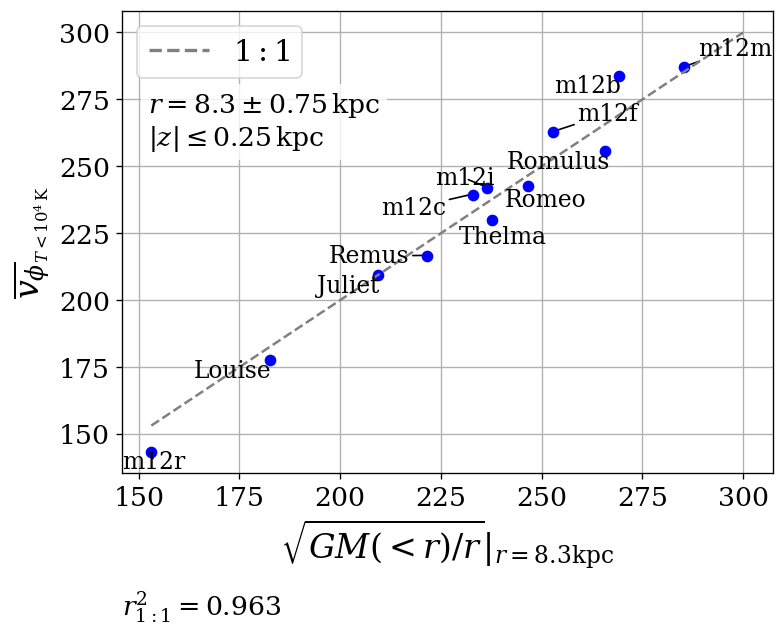

In [15]:
texts = []
xs = dfnew['vcirc']
ys = dfnew['v_dot_phihat_disc(T<=1e4)']
names = dfnew.index

fig = plt.figure(figsize=(7,5), dpi=120)
ax = fig.add_subplot(111)
ax.plot(xs, ys, 'bo')
ax.set_ylabel('$\\overline{v_\phi}_{_{T<10^{4}\,\mathrm{K}}}$')
ax.set_xlabel('$\sqrt{GM(<r)/r} \\vert_{r=8.3\mathrm{kpc}}$')
ax.plot([xs.min(),300.],[xs.min(),300.],color='gray',ls='--')
for x,y,name in zip(xs, ys, names):
    texts += [ax.annotate(name, (float(x*1.001), float(y*1.001)),
                          fontsize=14)]
adjust_text(texts, ax=ax, arrowprops={'arrowstyle':'-'})
#fig.set_size_inches(4., 4.*5./7., forward=True)

custom_lines = [Line2D([0], [0], ls='--', color='gray', lw=2.)]
ax.legend(custom_lines, ['$1:1$'])

sse = np.sum((ys-xs)**2.)
tss = np.sum((ys-np.mean(ys))**2.)
r2 = 1.-sse/tss
ax.annotate('$r^2_\mathrm{{1:1}}={0:0.3f}$'.format(r2),
            (0.,-0.25),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16)
            

ax.annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                 '$|z|\leq{1:0.2f}\,\mathrm{{kpc}}$'\
            .format(dfnew.attrs['dr']/2.,
                    dfnew.attrs['dz']/2.),
                (0.04, 0.83),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16, bbox=dict(facecolor='white', ec='none', alpha=0.8))
               
plt.show()

### Also showing what it looks like when we don't drop m12z and m12w

<IPython.core.display.Latex object>

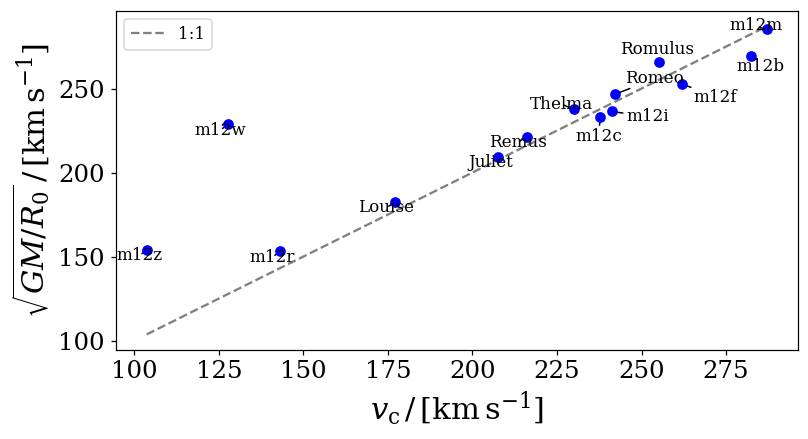

In [16]:
dm_den_viz.plt_gmr_vs_vc('dm_stats_dz1.0_20231211.h5', only_disks=False)

## Shell

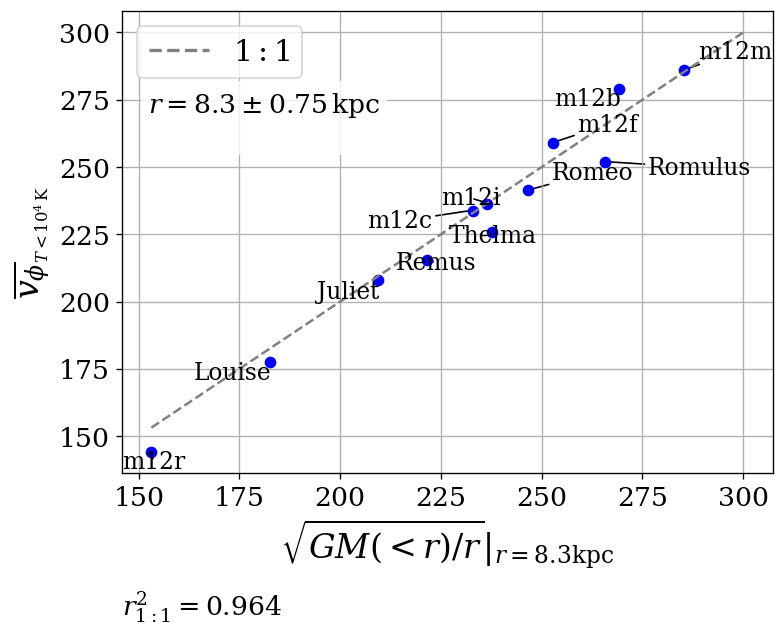

In [17]:
texts = []
xs = dfnew['vcirc']
ys = dfnew['v_dot_phihat_shell(T<=1e4)']
names = dfnew.index

fig = plt.figure(figsize=(7,5), dpi=120)
ax = fig.add_subplot(111)
ax.plot(xs, ys, 'bo')
ax.set_ylabel('$\\overline{v_\phi}_{_{T<10^{4}\,\mathrm{K}}}$')
ax.set_xlabel('$\sqrt{GM(<r)/r} \\vert_{r=8.3\mathrm{kpc}}$')
ax.plot([xs.min(),300.],[xs.min(),300.],color='gray',ls='--')
for x,y,name in zip(xs, ys, names):
    texts += [ax.annotate(name, (float(x*1.001), float(y*1.001)),
                          fontsize=14)]
adjust_text(texts, ax=ax, arrowprops={'arrowstyle':'-'})
#fig.set_size_inches(4., 4.*5./7., forward=True)

custom_lines = [Line2D([0], [0], ls='--', color='gray', lw=2.)]
ax.legend(custom_lines, ['$1:1$'])

ax.annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'\
            .format(dfnew.attrs['dr']/2.),
                (0.04, 0.83),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16, bbox=dict(facecolor='white', ec='none', alpha=0.8))

sse = np.sum((ys-xs)**2.)
tss = np.sum((ys-np.mean(ys))**2.)
r2 = 1.-sse/tss
ax.annotate('$r^2_\mathrm{{1:1}}={0:0.3f}$'.format(r2),
            (0.,-0.25),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16)
               
plt.show()

# $\vec{v}\cdot\hat{\phi}$ disc vs. shell

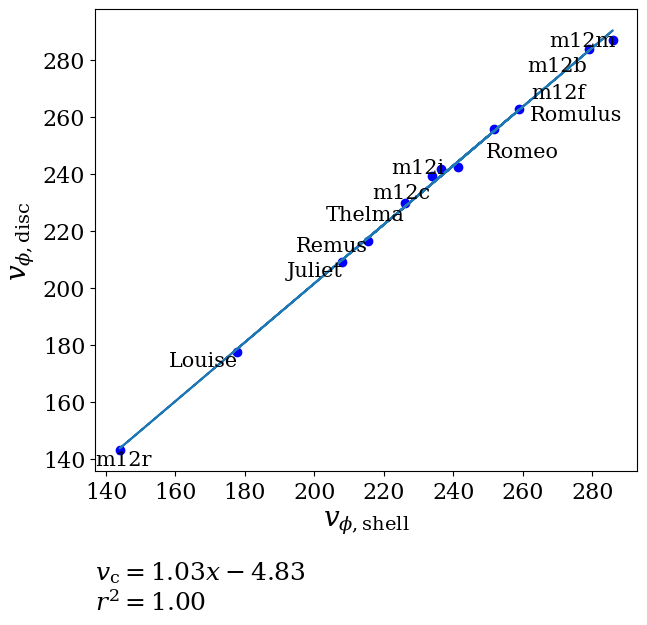

In [18]:
dm_den_viz.plt_slr('dm_stats_20220629.h5', 
                   'v_dot_phihat_shell(T<=1e4)',
                   'v_dot_phihat_disc(T<=1e4)',
                   ylabel = '$v_{\phi,\mathrm{disc}}$',
                   xlabel = '$v_{\phi,\mathrm{shell}}$',
                   xadjustment=None, yadjustment=None,
                   dropgals=['m12w','m12z'],
                   formula_y=-0.3)

## Checking $z$ distribution of cold gas

In [19]:
gal = cropper.load_data('m12i',['PartType0'])

Loading m12i


100% |####################################################################################################|


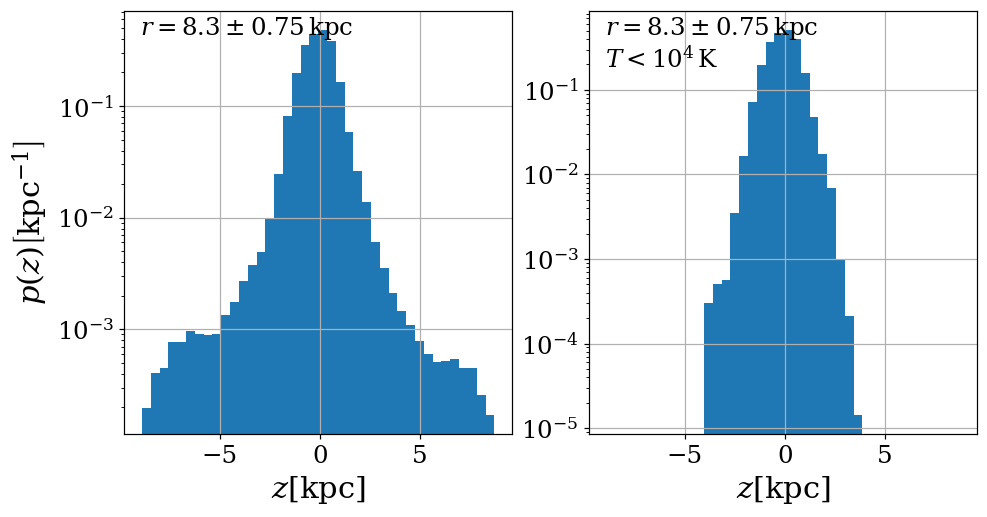

In [20]:
Ts = gal['PartType0']['T']
rs = gal['PartType0']['r']
iscold = Ts<1.e4
inshell = np.abs(rs-8.3)<=df.attrs['dr']/2.

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=False, sharex=True, 
                        dpi=110)
fig.subplots_adjust(wspace=0.2)
axs = axs.ravel()
_,bins,_ = axs[0].hist(gal['PartType0']['coord_rot'][:,2][inshell], bins=40,
                       density=True)
axs[0].set_ylabel('$p(z)\\left[\mathrm{kpc}^{-1}\\right]$')
axs[1].set_xlabel('$z[\mathrm{kpc}]$')
axs[0].set_xlabel('$z[\mathrm{kpc}]$')
axs[1].hist(gal['PartType0']['coord_rot'][:,2][iscold&inshell], bins=bins, 
            density=True)
axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'\
            .format(df.attrs['dr']/2.),
                (0.04, 0.99),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16, bbox=dict(facecolor='none', ec='none', alpha=0.8))
axs[1].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                '$T<10^4\,\mathrm{{K}}$'\
            .format(df.attrs['dr']/2.),
                (0.04, 0.99),
            xycoords='axes fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=16, bbox=dict(facecolor='none', ec='none', alpha=0.8))
plt.show()